**Name:** Sarah Sexton-Bowser <br/>
**Semester:** Spring 2020 <br/>
**Project area:** Analysis of state level data for crop yield and environmental conditions. </br>
**Objective**: To study the yield response of sorghum and corn to precipitation and drought in the SW Kansas crop district from 1995-2018. 

In [25]:
#Modules to utilize in code
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

# Load and Set-up the Data

**Sources of Data:** Data was downloaded direct from source. Any manipulation of data is done in python. 
1. Data for yield of sorghum and corn is obtained by USDA Quick Stats from USDA NASS. https://quickstats.nass.usda.gov/ 
2. Data for weather variables is obtained by NOAA. https://www7.ncdc.noaa.gov/CDO/CDODivisionalSelect.jsp  

In [26]:
# Load NASS Data for Yield Variable.   
all_district = pd.read_csv('C:/code/sorghum_acres_prediction/planting_price_NASS_1949_2019_all_districts.csv')
all_district = all_district.rename(columns={'Ag District':'District'})
SW = all_district.District.isin(['SOUTHWEST']) 
nass = all_district[SW].loc[:]
nass = nass.rename(columns={'Data Item': 'Data'})

In [27]:
# Load NOAA Data for Weather Variable. 
weather_data = pd.read_csv('C:/code/sorghum_acres_prediction/noaa_allmonth_1949_2019_alldistricts.txt', sep=",")

''' Division codes 
01 is NW, 02 is NC, 03 is NE, 04 is WC, 05 is C, 
06 is EC, 07 is SW, 08 is SC, 09 is SE
'''
SW = weather_data.Division.isin(['07']) 
weather_data = weather_data[SW].loc[:]

**Summary of manipulation of NOAA data to create variables of drought index, and preciptation by month and by growing season** </br>
1. Split string for 'YearMonth' column to create a Year and a Month column 
2. Change column names and types for compatability with processing
3. Create an annual calendar year precipitation variable 
4. Create a drought variable with the PSDI 
5. Create monthly variables for precipitation and drought

In [28]:
# Change NOAA Data variables YearMonth to string, and add columns with just year and just month for subsequent processing 
weather_data['YearMonth'] = weather_data['YearMonth'] .astype(str)
weather_data['PCP'] = weather_data['    PCP'].astype(float)
weather_data['PDSI'] = weather_data['   PDSI'].astype(float)
weather_data['Month'] = weather_data['YearMonth'].str[4:]
weather_data['Year'] = weather_data['YearMonth'].str[:4]
weather_data = weather_data.astype({'Year': 'int64'}) # changed year to int64 to mirror year key for other data frames

# Splice to year and precip variables and sum precip for all months in each year
years = weather_data.loc[0: , ['Year','PCP']]
annual_prec = years.groupby('Year').sum()
annual_prec = annual_prec.iloc[0:71]
annual_prec = annual_prec.reset_index() # made year a column so it is callable to merge
#annual_prec.info()

# Splice to month precip variables 
months = weather_data.loc[0: , ['Month','PCP', 'PDSI' ,'Year']]

In [29]:
# Create drought variable 
''' Palmer Drought Score Idex (PSDI value)
There are a few values in the magnitude of +7 or -7.  
PDSI values 
0 to -.5 = normal;
-0.5 to -1.0 = incipient drought; 
-1.0 to -2.0 = mild drought; 
-2.0 to -3.0 = moderate drought; 
-3.0 to -4.0 = severe drought; 
and greater than -4.0 = extreme drought.   '''

# Only considering drought and not extra moisture. Used boolean to mask years with above normal moisture. 
# Changed Drought Index values to Positive, so that an increase of severity of drought would be a positive number 
months['PDSI'] = months['PDSI'].mask(months['PDSI'] >= -.5,0)
months['PDSI'] = months['PDSI'].mask(months['PDSI'] <= -.5, (-1*months['PDSI']))

In [30]:
# Create variable of drought and precipitation for each month

# Wrote definition to process extracting the precipitation and drought index for each month
def getMonth (data, element):
    month_variable = data.Month.isin([element]) # Source: Fixed by AP Removed 'element' 
    month_variable = data[month_variable].loc[0: , ['Year', 'PCP', 'PDSI']]
    month_variable = month_variable.rename(columns={'PCP': 'PCP'+element, 'PDSI':'PDSI'+ element}) #'PCP': ('PCP'+ month)
    return month_variable 

# Ran each month in the getMonths function
January = getMonth(months,'01')
February = getMonth(months,'02')
March = getMonth(months,'03')
April = getMonth(months,'04')
May = getMonth(months,'05')
June = getMonth(months,'06')
July = getMonth(months,'07')
August = getMonth(months,'08')
September = getMonth(months,'09')
October = getMonth(months,'10')
November = getMonth(months,'11')
December = getMonth(months,'12')

# Merged for a single dataframe with all months 
month_index = (pd.merge(left=January, right=February, on='Year').merge(right=March, on='Year').merge(right=April, on='Year').merge(right=May, on='Year')
                .merge(right=June, on='Year').merge(right=July, on='Year').merge(right=August, on='Year').merge(right=September, on='Year')
                .merge(right=October, on='Year').merge(right=November, on='Year').merge(right=December, on='Year'))

**Summary of manipulation of NASS data to create variables of yield** </br>
1. Identify corn, irrigated corn, and sorghum for respective values in the rows
2. Change column names and types for compatability with processing

In [32]:
# Code to Develop dataframe from NASS Quick Stat Data

#Corn Yield Variable
corn_yield = nass.Data.isin(['CORN, GRAIN, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE']) 
corn_yield = nass[corn_yield].loc[0: , ['Year','Value']]
corn_yield=corn_yield.rename(columns={'Value': 'Corn_Yield'}).astype({'Corn_Yield': 'float32'}) # Change data type to float for mathmatical operations 

#Corn Yield Variable
corn_irryield = nass.Data.isin(['CORN, GRAIN, IRRIGATED - YIELD, MEASURED IN BU / ACRE']) 
corn_irryield = nass[corn_irryield].loc[0: , ['Year','Value']]
corn_irryield=corn_irryield.rename(columns={'Value': 'Corn_IrrYield'}).astype({'Corn_IrrYield': 'float32'}) # Change data type to float for mathmatical operations 

#Sorghum Yield Variable
sorghum_yield = nass.Data.isin(['SORGHUM, GRAIN - YIELD, MEASURED IN BU / ACRE']) 
sorghum_yield = nass[sorghum_yield].loc[0: , ['Year','Value']]
sorghum_yield=sorghum_yield.rename(columns={'Value': 'Sor_Yield'}).astype({'Sor_Yield': 'float32'}) # Change data type to float for mathmatical operations 

#Sorghum Acres Variable
sorghum_acres = nass.Data.isin(['SORGHUM - ACRES PLANTED']) 
sorghum_acres = nass[sorghum_acres].loc[0: , ['Year','Value']]
sorghum_acres['Value']= sorghum_acres['Value'].str.replace(',','') 
sorghum_acres=sorghum_acres.rename(columns={'Value': 'Sor_Acre'}).astype({'Sor_Acre': 'float32'}) # Change data type to float for mathmatical operations 

#Corn Acres Variable
corn_acres = nass.Data.isin(['CORN - ACRES PLANTED']) 
corn_acres = nass[corn_acres].loc[0: , ['Year','Value']]
corn_acres['Value']= corn_acres['Value'].str.replace(',','') 
corn_acres=corn_acres.rename(columns={'Value': 'Cor_Acres'}).astype({'Cor_Acres': 'float32'}) # Change data type to float for mathmatical operations 

**Create dataframe will all variables** 
1. Merge each data set on year
2. Select time period of interest

In [33]:
# Code to merge data frames created in prior cell with use of year as key to append 
df = pd.merge(left=sorghum_yield, right=corn_yield, on='Year').merge(right=corn_irryield, on='Year').merge(right=annual_prec, on='Year').merge(right=month_index, on='Year').merge(right=sorghum_acres, on ='Year').merge(right=corn_acres, on ='Year')
#df.tail()

# A data set of years with drought index for June, July, August and September starting in 1995
idx = (df.PDSI06+df.PDSI07+df.PDSI08+df.PDSI09) > 0
PDSI_SM = df.loc[idx]
PDSI_SM = PDSI_SM.loc[0:25]

# Extract data from time period of 1995-2018
df = df.loc[0:23]
#df.tail(20)
#PDSI_SM.tail(20)

# Now, time to evaluate the data
1. Run a for loop to test statistical significance of the independent variables for dependent variables of sorghum and corn yield respectively. 
2. Write a function to do linear fit 
3. Write a function to do a predicted y curve
4. Create predicted y curves, and values for variables of interest to chart

**Here is a loop to evaluate variables with a $P-value <= .01$**



In [38]:
# Test Corn Yield as a Dependent Variable
print('Variables of Statistical Significance of P-value <= .01 for Corn Yield ')
for column in df:
    if column == 'Corn_Yield': 
        continue   
    if column == 'Sor_Yield':   
        continue 
    if column == 'Corn_IrrYield': 
        continue
    if column == 'PDSI11':
        continue
    if column == 'PDSI12':
        continue
    else: 
        slope, intercept, r_value, p_value, std_err = stats.linregress((df[column]), df.Corn_Yield)
        if p_value <= .001:
            print(column,": ", "p_value is", p_value, 'r_value is', r_value)
            
# Test Sorghum Yield as a Dependent Variable
print('Variables of Statistical Significance of P-value <= .01 for Sorghum Yield')
for column in df:
    if column == 'Corn_Yield': 
        continue   
    if column == 'Sor_Yield': 
        continue  
    if column == 'Corn_IrrYield': 
        continue  
    if column == 'PDSI11':
        continue
    if column == 'PDSI12':
        continue
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress((df[column]), df.Sor_Yield) 
        if p_value <= .001:
                print(column, "p_value is", p_value, 'r_value is', r_value)            

Variables of Statistical Significance of P-value <= .01 for Corn Yield 
PCP :  p_value is 2.1810123802344417e-05 r_value is 0.752922671141079
PDSI06 :  p_value is 2.528181725081591e-05 r_value is -0.7491410284094417
PCP07 :  p_value is 0.0006014564679010781 r_value is 0.6489936184525614
PDSI07 :  p_value is 1.4946410363296934e-05 r_value is -0.7623045223922531
PDSI08 :  p_value is 0.0006788571336051086 r_value is -0.6442921856429618
PDSI09 :  p_value is 0.0009204052671973953 r_value is -0.6321177371443312
PDSI10 :  p_value is 0.000757528336634953 r_value is -0.6399657928802236
Variables of Statistical Significance of P-value <= .01 for Sorghum Yield
PCP p_value is 1.79289696670966e-05 r_value is 0.757839210283493
PDSI06 p_value is 3.339645813943606e-05 r_value is -0.741832253545564
PCP07 p_value is 0.00040967812146808815 r_value is 0.6634057984947686
PDSI07 p_value is 1.743711927639302e-05 r_value is -0.7585280310334552
PDSI08 p_value is 3.052495967930682e-05 r_value is -0.744219291613

In [39]:
# Test yield of Sorghum and Corn as Dependent Variable in Years where summer months is in drought classification 
print('Variables of Statistical Significance of P-value <= .01 for Corn Yield in years with Summer Drought Index')
for column in PDSI_SM:
    if column == 'Sor_Acre': 
        continue  
    if column == 'Corn_Yield': 
        continue   
    if column == 'Sor_Yield': 
        continue   
    if column == 'Cor_Acres': 
        continue  
    if column == 'Year': 
        continue 
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress((PDSI_SM[column]), PDSI_SM.Corn_Yield) 
        if p_value <= .01:
                print(column, "p_value is", p_value, 'r_value is', r_value)
                
print('Variables of Statistical Significance of P-value <= .01 for Sorghum Yield in years with Summer Drought Index')
for column in PDSI_SM:
    if column == 'Sor_Acre': 
        continue   
    if column == 'Cor_Acres': 
        continue  
    if column == 'Corn_Yield': 
        continue   
    if column == 'Sor_Yield': 
        continue   
    if column == 'Corn_IrrYield': 
        continue  
    if column == 'Year': 
        continue 
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress((PDSI_SM[column]), PDSI_SM.Sor_Yield) 
        if p_value <= .01:
                print(column, "p_value is", p_value, 'r_value is', r_value)

Variables of Statistical Significance of P-value <= .01 for Corn Yield in years with Summer Drought Index
PDSI01 p_value is 0.009273027315250886 r_value is -0.7693527668369923
PDSI02 p_value is 0.009530069155991307 r_value is -0.7676405157699785
PDSI03 p_value is 0.0008557667661714109 r_value is -0.8771954869970042
PDSI04 p_value is 0.00609772432956766 r_value is -0.793959297075344
PDSI05 p_value is 0.0035560466041351336 r_value is -0.8215405544945131
PDSI06 p_value is 0.009349104967841417 r_value is -0.7688425341969525
PDSI07 p_value is 0.0027599271680675192 r_value is -0.8331167393400382
Variables of Statistical Significance of P-value <= .01 for Sorghum Yield in years with Summer Drought Index
PCP05 p_value is 0.009892099322467684 r_value is 0.7652832760050848
PDSI06 p_value is 0.006217452350799096 r_value is -0.7928829774074402
PDSI07 p_value is 0.0020587155763328708 r_value is -0.8455204369516885
PDSI08 p_value is 0.00030888204102022684 r_value is -0.9056563810007044
PDSI09 p_valu

**Here is a function to return linear relationship, and y curve for the x and y variables**

In [42]:
# This is a function to return linear regression for x(independent variable), y(dependent variable) 
def lin_fit (x, y):
    lin_fit = stats.linregress(x,y)
    y_pred = lin_fit.intercept + lin_fit.slope * x 
    return print('slope:',lin_fit.slope, 'intercept:',lin_fit.intercept, 'r:',lin_fit.rvalue, 'r-squared:',lin_fit.rvalue**2, 'p-value:',lin_fit.pvalue)

# This is a function to return linear y prediction curve
def y_pred (x, y):
    lin_fit = stats.linregress(x,y)
    y_pred = lin_fit.intercept + lin_fit.slope * x 
    return y_pred

In [43]:
#Yield Response to Annual Precipitation
y_sy_pcp = y_pred(df.PCP, df.Sor_Yield)
slope, intercept, r_value, p_value, std_err = stats.linregress(df.PCP, df.Sor_Yield)
sy_pcp_slope = slope
sy_pcp_pvalue = p_value
sy_pcp_r = r_value
sy_pcp_r_squared = r_value**2

y_cy_pcp= y_pred(df.PCP, df.Corn_Yield)
slope, intercept, r_value, p_value, std_err = stats.linregress(df.PCP, df.Corn_Yield)
cy_pcp_slope = slope
cy_pcp_pvalue = p_value
cy_pcp_r = r_value
cy_pcp_r_squared = r_value**2

y_ciy_pcp= y_pred(df.PCP, df.Corn_IrrYield)
slope, intercept, r_value, p_value, std_err = stats.linregress(df.PCP, df.Corn_IrrYield)
ciy_pcp_slope = slope
ciy_pcp_pvalue = p_value
ciy_pcp_r = r_value
ciy_pcp_r_squared = r_value**2

#Yield Response to July Precipitation
y_sy_PCP07 = y_pred(df.PCP07, df.Sor_Yield)
slope, intercept, r_value, p_value, std_err = stats.linregress(df.PCP07, df.Sor_Yield)
sy_PCP07_slope = slope
sy_PCP07_pvalue = p_value
sy_PCP07_r = r_value
sy_PCP07_r_squared = r_value**2

y_cy_PCP07 = y_pred(df.PCP07, df.Corn_Yield)
slope, intercept, r_value, p_value, std_err = stats.linregress(df.PCP07, df.Corn_Yield)
cy_PCP07_slope = slope
cy_PCP07_pvalue = p_value
cy_PCP07_r = r_value
cy_PCP07_r_squared = r_value**2

y_ciy_PCP07 = y_pred(df.PCP07, df.Corn_IrrYield)
slope, intercept, r_value, p_value, std_err = stats.linregress(df.PCP07, df.Corn_IrrYield)
ciy_PCP07_slope = slope
ciy_PCP07_pvalue = p_value
ciy_PCP07_r = r_value
ciy_PCP07_r_squared = r_value**2

#Yield Response in Years of Summer Drought to July Precipitation
y_sy_PDSMI07dht = y_pred(PDSI_SM.PDSI07, PDSI_SM.Sor_Yield)
slope, intercept, r_value, p_value, std_err = stats.linregress(PDSI_SM.PDSI07, PDSI_SM.Sor_Yield)
sy_PDSMI07dht_slope = slope
sy_PDSMI07dht_pvalue = p_value
sy_PDSMI07dht_r = r_value
sy_PDSMI07dht_r_squared = r_value**2

y_cy_PDSMI07dht = y_pred(PDSI_SM.PDSI07, PDSI_SM.Corn_Yield)
slope, intercept, r_value, p_value, std_err = stats.linregress(PDSI_SM.PDSI07, PDSI_SM.Corn_Yield)
cy_PDSMI07dht_slope = slope
cy_PDSMI07dht_pvalue = p_value
cy_PDSMI07dht_r = r_value
cy_PDSMI07dht_r_squared = r_value**2

# Visualize the Data

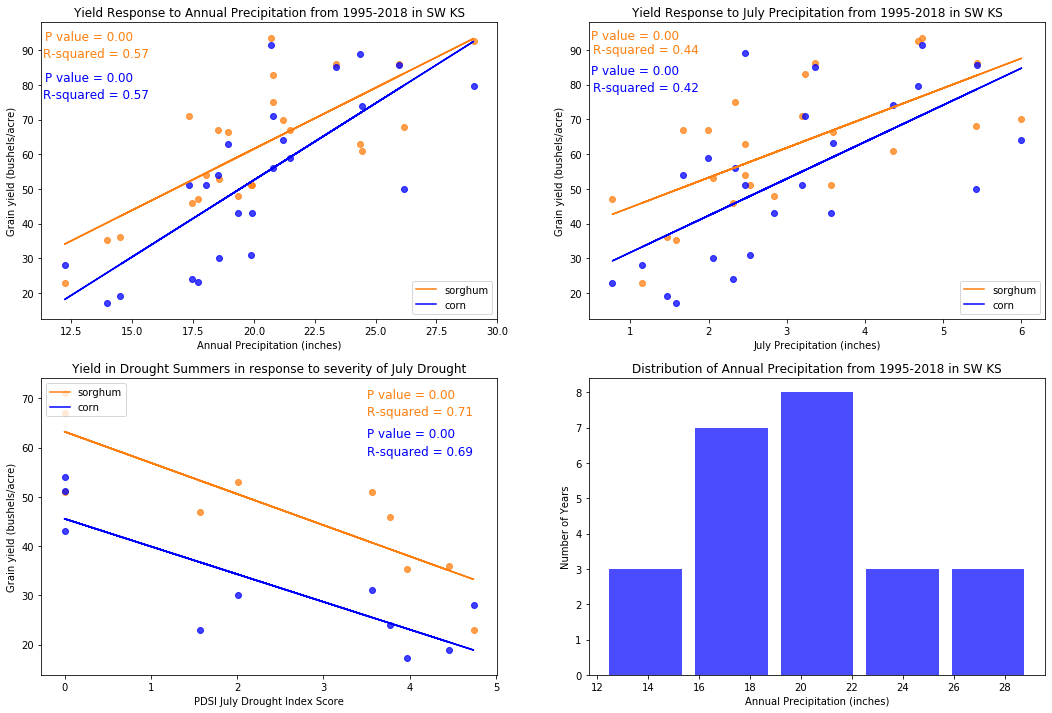

In [44]:
# Explore data

plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
#Sorghum
plt.plot(df["PCP"], y_sy_pcp, 'C1', label='sorghum')
plt.scatter(df["PCP"], df["Sor_Yield"], facecolor='C1', alpha=0.75)
plt.xlabel('Annual Precipitation (inches)')
plt.text(11.4, 93, 'P value = %0.2f'% sy_pcp_pvalue, fontsize=12, color = 'C1')
plt.text(13.5, 91, 'R-squared = %0.2f'%sy_pcp_r_squared, fontsize=12, horizontalalignment='center', verticalalignment='top', color = 'C1')
#Corn Non Irrigated 
plt.title('Yield Response to Annual Precipitation from 1995-2018 in SW KS')
plt.plot(df["PCP"], y_cy_pcp, '-b', label='corn')
plt.scatter(df["PCP"], df["Corn_Yield"], facecolor='b', alpha=0.75, color = 'b')
plt.text(11.4, 81, 'P value = %0.2f'% cy_pcp_pvalue, fontsize=12, color = 'b')
plt.text(13.5, 79, 'R-squared = %0.2f'%cy_pcp_r_squared, fontsize=12, horizontalalignment='center', verticalalignment='top', color = 'b')
plt.ylabel('Grain yield (bushels/acre)')
plt.legend(loc='lower right')

plt.subplot(2,2,2)
plt.title('Yield Response to July Precipitation from 1995-2018 in SW KS')
#Sorghum
plt.plot(df["PCP07"], y_sy_PCP07, 'C1', label='sorghum')
plt.scatter(df["PCP07"], df["Sor_Yield"],  facecolor='C1', alpha=0.75)
plt.text(.5, 93, 'P value = %0.2f'% sy_PCP07_pvalue, fontsize=12, color = 'C1')
plt.text(1.2, 92, 'R-squared = %0.2f'%sy_PCP07_r_squared, fontsize=12, horizontalalignment='center', verticalalignment='top', color = 'C1')
#Corn Non Irrigated 
plt.plot(df["PCP07"], y_cy_PCP07, 'b', label='corn')
plt.scatter(df["PCP07"], df["Corn_Yield"], facecolor='b', alpha=0.75)
plt.text(.5, 83, 'P value = %0.2f'% cy_PCP07_pvalue, fontsize=12, color = 'b')
plt.text(1.2, 81, 'R-squared = %0.2f'%cy_PCP07_r_squared, fontsize=12, horizontalalignment='center', verticalalignment='top', color = 'b')
plt.xlabel('July Precipitation (inches)')
plt.ylabel('Grain yield (bushels/acre)')
plt.legend(loc='lower right')

plt.subplot(2,2,3)
plt.title('Yield in Drought Summers in response to severity of July Drought')
#Sorghum
plt.plot(PDSI_SM["PDSI07"], y_sy_PDSMI07dht, 'C1', label='sorghum', color = 'C1')
plt.scatter(PDSI_SM["PDSI07"], PDSI_SM["Sor_Yield"],  facecolor='C1', alpha=0.75)
plt.text(3.5, 70, 'P value = %0.2f'% sy_PDSMI07dht_pvalue, fontsize=12,color = 'C1')
plt.text(4.12, 68.5, 'R-squared = %0.2f'%sy_PDSMI07dht_r_squared, fontsize=12, horizontalalignment='center', verticalalignment='top', color = 'C1')
#Corn Non Irrigated
plt.plot(PDSI_SM["PDSI07"], y_cy_PDSMI07dht, 'b', label='corn')
plt.scatter(PDSI_SM["PDSI07"], PDSI_SM["Corn_Yield"], facecolor='b', alpha=0.75)
plt.text(3.5, 62, 'P value = %0.2f'% cy_PDSMI07dht_pvalue, fontsize=12, color = 'b')
plt.text(4.12, 60.5, 'R-squared = %0.2f'%cy_PDSMI07dht_r_squared, fontsize=12, horizontalalignment='center', verticalalignment='top',color = 'b')
plt.xlabel('PDSI July Drought Index Score')
plt.ylabel('Grain yield (bushels/acre)')
plt.legend(loc= "upper left")
#plt.savefig('NWdistrict.png', bbox_inches='tight', dpi=200, pad_inches = 0)

plt.subplot(2,2,4)
plt.title('Distribution of Annual Precipitation from 1995-2018 in SW KS')
N = 5
n, bins, patches = plt.hist(x=df.PCP, bins=N, color='blue',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Annual Precipitation (inches)')
plt.ylabel('Number of Years')
plt.show()

**Test poly relationship of the variables**

In [15]:
# Reference the protor_test and Frontier tutorials 
parsor = np.polyfit(df.PCP, df.Sor_Yield, 2)
parcor = np.polyfit(df.PCP, df.Corn_Yield, 2)
parirrcor = np.polyfit(df.PCP, df.Corn_IrrYield, 2)

In [16]:
polyfunsor = np.poly1d(parsor) # Create objec
polyfuncor = np.poly1d(parcor) # Create objec
polyfunirrcorn = np.poly1d(parirrcor) # Create objec

In [17]:
pcp_min = np.min(df.PCP)
pcp_max = np.max(df.PCP)
pcp_pred = np.arange(pcp_min, pcp_max, 0.001)
sy = polyfunsor(pcp_pred)
cy = polyfuncor(pcp_pred)
icy= polyfunirrcorn(pcp_pred)

**Set up the production function for efficiency**

In [18]:
N = 10 # Number of bins
pcp_bins = np.linspace(pcp_min, pcp_max , N)
np.round(pcp_bins)

array([12., 14., 16., 18., 20., 22., 23., 25., 27., 29.])

In [19]:
# Corn Yield for each PCP bin 
cy_frontier_yield_obs = np.array([])
cy_frontier_pcp_obs = np.array([])

for n in range(len(pcp_bins)-1): 
    cy_idx = (df.PCP >= pcp_bins[n]) & (df.PCP < pcp_bins[n+1])
    
    if np.all(cy_idx == False):
        continue
        
    else:
        cy_pcp_bin = df.loc[cy_idx, 'PCP']
        cy_yield_bin = df.loc[cy_idx, 'Corn_Yield']
        
        cy_max_yield_bin = np.amax(cy_yield_bin)
        cy_idx_max_yield_bin = np.argmax(cy_yield_bin.values)
        cy_corresponding_pcp_bin = cy_pcp_bin.iloc[cy_idx_max_yield_bin]
        
        cy_frontier_pcp_obs = np.append(cy_frontier_pcp_obs, cy_corresponding_pcp_bin)
        cy_frontier_yield_obs = np.append(cy_frontier_yield_obs, cy_max_yield_bin)

# Display outputs. For simplicity I rounded the outputs at the time of printing.
print(np.round(cy_frontier_pcp_obs))
print(np.round(cy_frontier_yield_obs))

[12. 15. 17. 19. 21. 23. 24. 26.]
[28. 19. 51. 63. 92. 85. 89. 86.]


In [20]:
# Sorghum Yield for each PCP bin 
sy_frontier_yield_obs = np.array([])
sy_frontier_pcp_obs = np.array([])

for n in range(len(pcp_bins)-1): 
    sy_idx = (df.PCP >= pcp_bins[n]) & (df.PCP < pcp_bins[n+1])
    
    if np.all(sy_idx == False):
        continue
        
    else:
        sy_pcp_bin = df.loc[sy_idx, 'PCP']
        sy_yield_bin = df.loc[sy_idx, 'Sor_Yield']
        
        sy_max_yield_bin = np.amax(sy_yield_bin)
        sy_idx_max_yield_bin = np.argmax(sy_yield_bin.values)
        sy_corresponding_pcp_bin = sy_pcp_bin.iloc[sy_idx_max_yield_bin]
        
        sy_frontier_pcp_obs = np.append(sy_frontier_pcp_obs, sy_corresponding_pcp_bin)
        sy_frontier_yield_obs = np.append(sy_frontier_yield_obs, sy_max_yield_bin)

# Display outputs. For simplicity I rounded the outputs at the time of printing.
print(np.round(sy_frontier_pcp_obs))
print(np.round(sy_frontier_yield_obs))

[14. 15. 17. 19. 21. 23. 24. 26.]
[35. 36. 71. 67. 94. 86. 63. 86.]


In [21]:
# Define Cobb-Douglas model for Corn Yield Response to Annual PCP
np.seterr(divide = 'ignore', invalid='ignore');

cobb_douglas = lambda x, a, b, c: a + b * np.log(x) + c * np.log(x)**2

# Define initial guess for the parameters of the Cobb-Douglas model
cy_par0 = [1,1,1]

# Fit Cobb-Douglas model
cy_param_bounds=([-np.inf,0,-np.inf],[np.inf,1,np.inf])
cy_par = curve_fit(cobb_douglas, cy_frontier_pcp_obs, cy_frontier_yield_obs, cy_par0, bounds= cy_param_bounds)
print('Optimized parameters:', np.round(cy_par[0]))

# Create range of x values using a step increase (default). This will give us enough detail
# to have an accurate curve for most practical purposes.
cy_frontier_pcp_line = np.arange(0, pcp_max)
cy_frontier_yield_line = cobb_douglas(cy_frontier_pcp_line, *cy_par[0])

print('The frontier was built using a total of:', len(cy_frontier_pcp_line), 'points')

Optimized parameters: [-90.   1.  17.]
The frontier was built using a total of: 30 points


In [22]:
# Define Cobb-Douglas model for Sorghum Yield Response to Annual PCP
np.seterr(divide = 'ignore', invalid='ignore');
# Define Cobb-Douglas model
cobb_douglas = lambda x, a, b, c: a + b * np.log(x) + c * np.log(x)**2

# Define initial guess for the parameters of the Cobb-Douglas model
sy_par0 = [1,1,1]

# Fit Cobb-Douglas model
sy_param_bounds=([-np.inf,0,-np.inf],[np.inf,1,np.inf])
sy_par = curve_fit(cobb_douglas, sy_frontier_pcp_obs, sy_frontier_yield_obs, sy_par0, bounds= sy_param_bounds)
print('Optimized parameters:', np.round(sy_par[0]))

# Create range of x values using a step increase (default). This will give us enough detail
# to have an accurate curve for most practical purposes.
sy_frontier_pcp_line = np.arange(0, pcp_max)
sy_frontier_yield_line = cobb_douglas(sy_frontier_pcp_line, *sy_par[0])

print('The frontier was built using a total of:', len(sy_frontier_pcp_line), 'points')

Optimized parameters: [-46.   1.  12.]
The frontier was built using a total of: 30 points


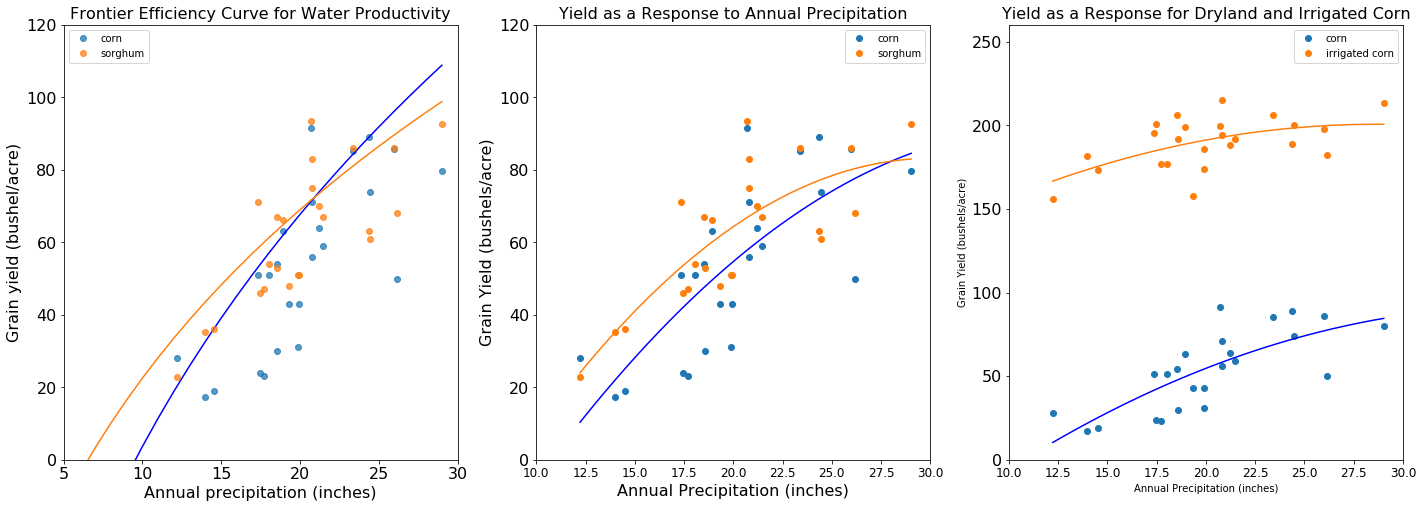

In [23]:
plt.figure(figsize=(24,8))

plt.subplot(1,3,1)
plt.title('Frontier Efficiency Curve for Water Productivity', size=16)
# Corn
plt.plot(df.PCP, df.Corn_Yield, 'o', alpha=0.75, label='corn')
plt.plot(cy_frontier_pcp_line, cy_frontier_yield_line, 'b')
# Sorghum
plt.plot(df.PCP, df.Sor_Yield, 'o', alpha=0.75, label='sorghum')
plt.plot(sy_frontier_pcp_line, sy_frontier_yield_line, 'C1')
plt.legend(loc= "upper left")
plt.xlabel('Annual precipitation (inches)', size=16)
plt.ylabel('Grain yield (bushel/acre)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(5,30)
plt.ylim(0,120)

plt.subplot(1,3,2)
plt.title('Yield as a Response to Annual Precipitation', size=16)
plt.plot(df.PCP, df.Corn_Yield, 'o', label='corn')
plt.plot(df.PCP, df.Sor_Yield,'o', label='sorghum')
plt.plot(pcp_pred, cy,'b')
plt.plot(pcp_pred, sy, 'C1')
plt.xlabel('Annual Precipitation (inches)', size=16)
plt.ylabel('Grain Yield (bushels/acre)', size=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.xlim(10,30)
plt.ylim(0,120)
plt.legend()

plt.subplot(1,3,3)
plt.title('Yield as a Response for Dryland and Irrigated Corn', size=16)
plt.plot(df.PCP, df.Corn_Yield, 'o', label='corn')
plt.plot(df.PCP, df.Corn_IrrYield,'o', label='irrigated corn')
plt.plot(pcp_pred, cy,'b')
plt.plot(pcp_pred, icy, 'C1')
plt.xlabel('Annual Precipitation (inches)')
plt.ylabel('Grain Yield (bushels/acre)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.xlim(10,30)
plt.ylim(0,260)
plt.legend()

plt.show()

## With time, I would:
1. Add the Lloyd Stone curve for Sorghum and Corn charts for comparision
2. Pull KDA water use records for irrigated corn and add annual precip + irrigation for an irrigated curve
3. Evaluate and plot the differences between the poly curve and the efficiency curve? Maybe by year? How far off was each year's yield from the highest yield response to that precipitation bin?